# 프로젝트 - Movielens 영화 추천 실습

- 별점을 시청횟수로 해석해서 생각
- 사용자가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외

# 1. 데이터 준비와 전처리

In [1]:
import pandas as pd
import os

rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


평점 3점 이상의 비율은?

In [2]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [3]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [4]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [5]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
print('len(user) :',ratings['user_id'].nunique())
print('len(movies) :',ratings['movie_id'].nunique())

len(user) : 6039
len(movies) : 3628


# 2. 데이터 분석

### 2.1 ratings Dataframe 정보 확인

In [7]:
ratings.head()

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    836478 non-null  int64
 1   movie_id   836478 non-null  int64
 2   counts     836478 non-null  int64
 3   timestamp  836478 non-null  int64
dtypes: int64(4)
memory usage: 31.9 MB


In [9]:
ratings.describe()

,user_id,movie_id,counts,timestamp
count,836478.000000,836478.000000,836478.000000,8.364780e+05
mean,3033.120626,1849.099114,3.958293,9.721628e+08
std,1729.255651,1091.870094,0.762280,1.206216e+07
min,1.000000,1.000000,3.000000,9.567039e+08
25%,1531.000000,1029.000000,3.000000,9.652795e+08
50%,3080.000000,1747.000000,4.000000,9.728388e+08
75%,4485.000000,2763.000000,5.000000,9.752064e+08
max,6040.000000,3952.000000,5.000000,1.046455e+09


In [10]:
# ratings 결측치 유무 확인
ratings.isnull().sum()

user_id      0
movie_id     0
counts       0
timestamp    0
dtype: int64

### 2.2 movies Dataframe 정보 확인

In [11]:
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
movies.info() # 텍스트 정보 담고있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genre     3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [13]:
movies.describe()

,movie_id
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


In [14]:
# movies 결측치 유무 확인
movies.isnull().sum()

movie_id    0
title       0
genre       0
dtype: int64

In [15]:
# 위에서 이미 실행한 코드
print('ratings에 있는 유니크한 영화 개수 :',ratings['user_id'].nunique())
print('ratings에 있는 유니크한 사용자 수:',ratings['movie_id'].nunique())

ratings에 있는 유니크한 영화 개수 : 6039
ratings에 있는 유니크한 사용자 수: 3628


### 2.3 아래 3가지 항목 확인
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

In [16]:
# 영화를 본 사용자의 수 
users_per_movie = ratings.groupby('movie_id')['user_id'].count()
print(users_per_movie.head(10))
print(users_per_movie[2858])

movie_id
1     2000
2      551
3      339
4      102
5      214
6      868
7      391
8       49
9       57
10     786
Name: user_id, dtype: int64
3211


In [17]:
# ratings에 있는 unique 영화 개수
print('ratings에 있는 유니크한 영화 개수 :',ratings['user_id'].nunique())

ratings에 있는 유니크한 영화 개수 : 6039


In [18]:
# ratings에 있는 unique 사용자 수
print('ratings에 있는 유니크한 사용자 수:',ratings['movie_id'].nunique())

ratings에 있는 유니크한 사용자 수: 3628


#### 인기 있다는 기준을 평점의 합계로 해야할까 아니면 평점의 평균으로 해야할까?

In [19]:
# 가장 인기 있는 영화 30개(인기순) - 1.평점 합계로
best30_count = ratings.groupby('movie_id')['counts'].sum().sort_values(ascending=False).head(30)
best30_count

movie_id
2858    14449
260     13178
1196    12648
2028    11348
1210    11303
1198    11179
593     11096
2571    10903
2762    10703
589     10513
608     10465
527     10317
110     10125
318     10085
1270    10081
858      9965
1197     9866
480      9601
1617     9515
2396     9503
1580     9057
296      9053
2997     8964
1265     8727
1097     8696
356      8679
1240     8571
1        8475
2716     8282
1214     8244
Name: counts, dtype: int64

In [20]:
# 가장 인기 있는 영화 30개(인기순) - 2. 평점의 평균으로 
best30_count_m = ratings.groupby('movie_id')['counts'].mean().sort_values(ascending=False).head(30)
best30_count_m

movie_id
1830    5.000000
3607    5.000000
3800    5.000000
3280    5.000000
989     5.000000
1360    5.000000
3656    5.000000
687     5.000000
3881    5.000000
787     5.000000
1420    5.000000
1787    5.000000
1553    5.000000
3382    5.000000
3205    5.000000
3236    5.000000
572     5.000000
3172    5.000000
3233    5.000000
3245    4.800000
53      4.750000
3232    4.750000
2503    4.666667
2197    4.666667
3866    4.666667
2905    4.647059
2019    4.629690
670     4.603774
858     4.598523
318     4.596627
Name: counts, dtype: float64

In [21]:
ratings[ratings['movie_id'] == 1830]

,user_id,movie_id,counts,timestamp
465274,2869,1830,5,972439040


In [22]:
ratings[ratings['movie_id'] == 3607]

,user_id,movie_id,counts,timestamp
970914,5851,3607,5,957756608


> 평점의 평균으로 한다면 그 영화를 본 단 1명의 사용자만이  5점으로 평가해도 평점이 5점으로 좋기 때문에 평점의 합계로 인기의 정도를 평가하도록 하자! -> best30_count 사용할 것

In [23]:
# movie title과 함께 확인해보기
best30_df = pd.merge(best30_count,movies, on='movie_id')
best30_df

,movie_id,counts,title,genre
0,2858,14449,American Beauty (1999),Comedy|Drama
1,260,13178,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
2,1196,12648,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
3,2028,11348,Saving Private Ryan (1998),Action|Drama|War
4,1210,11303,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
5,1198,11179,Raiders of the Lost Ark (1981),Action|Adventure
6,593,11096,"Silence of the Lambs, The (1991)",Drama|Thriller
7,2571,10903,"Matrix, The (1999)",Action|Sci-Fi|Thriller
8,2762,10703,"Sixth Sense, The (1999)",Thriller
9,589,10513,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller


In [24]:
# 사용자별 몇 개의 영화를 봤을지에 대한 통계
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

In [25]:
# 사용자별 평점 중앙값에 대한 통계
user_median = ratings.groupby('user_id')['counts'].median()
user_median.describe()

count    6039.000000
mean        4.055970
std         0.432143
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: counts, dtype: float64

In [26]:
# best30_df 에서 있기있는 영화 장르 보기
best30_df.groupby('genre')['counts'].count().sort_values(ascending=False)

genre
Action|Sci-Fi|Thriller                 3
Action|Drama|War                       2
Comedy|Romance                         2
Action|Adventure                       1
Comedy|Drama                           1
Drama|War                              1
Drama|Thriller                         1
Drama                                  1
Crime|Film-Noir|Mystery|Thriller       1
Crime|Drama|Thriller                   1
Crime|Drama                            1
Comedy|Sci-Fi                          1
Comedy|Romance|War                     1
Comedy|Horror                          1
Comedy                                 1
Action|Adventure|Comedy|Romance        1
Children's|Drama|Fantasy|Sci-Fi        1
Animation|Children's|Comedy            1
Action|Horror|Sci-Fi|Thriller          1
Action|Crime|Drama                     1
Action|Adventure|Sci-Fi                1
Action|Adventure|Romance|Sci-Fi|War    1
Action|Adventure|Fantasy|Sci-Fi        1
Action|Adventure|Drama|Sci-Fi|War      1
Action|Adv

In [27]:
# |로 분리해야 장르별 수 파악 가능하다
from collections import Counter
best30_genres = []
for genre in best30_df['genre'].values:
    best30_genres.extend(genre.split('|'))

genre_count = Counter(best30_genres)
genre_count.most_common()

[('Action', 14),
 ('Drama', 11),
 ('Sci-Fi', 11),
 ('Comedy', 10),
 ('Thriller', 8),
 ('Adventure', 7),
 ('War', 6),
 ('Romance', 5),
 ('Crime', 4),
 ('Fantasy', 2),
 ("Children's", 2),
 ('Horror', 2),
 ('Film-Noir', 1),
 ('Mystery', 1),
 ('Animation', 1)]

> **Action, Drama, Sci-Fi** 장르의 영화 선호도가 높다고 파악 가능하다.

# 3. 모델 검증을 위한 사용자 초기 정보 세팅
추천시스템은 처음에 유저의 취향인 아티스트 5개 입력 받는 과정을 거침. <br>
우리도 추천 시스템의 추후 검증 과정을 위해 동일한 과정이 필요하다. <br>
내가 좋아하는 영화 5가지를 기존 데이터에 추가해보자! 

> 난 개인적으로 Action|Adventure 장르가 좋기 때문에 이 장르의 영화중 인기 있는 영화를 택할 것이다.

In [28]:
movies[movies['genre'].isin(['Action|Adventure'])].merge(ratings,on='movie_id').groupby('title')['counts'].sum().sort_values(ascending=False)[:30]

title
Raiders of the Lost Ark (1981)                        11179
Indiana Jones and the Last Crusade (1989)              6622
Indiana Jones and the Temple of Doom (1984)            3894
Highlander (1986)                                      2730
Poseidon Adventure, The (1972)                         1989
Conan the Barbarian (1982)                             1787
Adventures of Robin Hood, The (1938)                   1474
Ghost and the Darkness, The (1996)                     1349
Waterworld (1995)                                      1260
Mortal Kombat (1995)                                    674
Golden Voyage of Sinbad, The (1974)                     478
Sanjuro (1962)                                          316
Sinbad and the Eye of the Tiger (1977)                  313
Red Sonja (1985)                                        311
Avengers, The (1998)                                    284
Fled (1996)                                             198
Mortal Kombat: Annihilation (1997)

> 아니 2000년도 이전 옛날영화가 대부분이네,,? <br>
> Action|Adventure 영화는 다 내가 모르는 영화다..<br>
> 그냥 내가 아는 영화가 가장 많은 장르의 인기 영화를 가져와보자

In [29]:
movies[movies['genre'].isin(['Comedy|Romance'])].merge(ratings,on='movie_id').groupby('title')['counts'].sum().sort_values(ascending=False)[:30]

title
Shakespeare in Love (1998)             9503
Groundhog Day (1993)                   8727
When Harry Met Sally... (1989)         6237
Annie Hall (1977)                      5386
Clueless (1995)                        4670
Four Weddings and a Funeral (1994)     4429
Pretty Woman (1990)                    3572
Dave (1993)                            3540
Sleepless in Seattle (1993)            3537
Office Space (1999)                    3184
Wedding Singer, The (1998)             2943
L.A. Story (1991)                      2920
Notting Hill (1999)                    2703
Much Ado About Nothing (1993)          2611
My Best Friend's Wedding (1997)        2598
Strictly Ballroom (1992)               2576
You've Got Mail (1998)                 2572
Philadelphia Story, The (1940)         2460
10 Things I Hate About You (1999)      2210
While You Were Sleeping (1995)         2189
Truth About Cats & Dogs, The (1996)    2155
Desperately Seeking Susan (1985)       2038
Hudsucker Proxy, The (1994

이 5가지 영화를 추가할 것이다
>- When Harry Met Sally... (1989)         6237
>- Clueless (1995)                        4670
>- Pretty Woman (1990)                    3572
>- Notting Hill (1999)                    2703
>- 10 Things I Hate About You (1999)      2210

In [30]:
# ratings 형식 확인
ratings.head()

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [31]:
my_favorite = [6237,4670,3572,2703,2210]

# 'minyeong'이라는 user_id가 위 영화의 평점을 다 4점을 줬다고 가정
my_movielist = pd.DataFrame({'user_id': ['minyeong']*5, 'movie_id': my_favorite, 'counts':[4]*5,'timestamp':[978300275]*5})

if not ratings.isin({'user_id':['minyeong']})['user_id'].any():  # user_id에 'minyeong'이라는 데이터가 없다면
    ratings = ratings.append(my_movielist)                           # 위에 임의로 만든 my_favorite 데이터를 추가

ratings.tail(10)       # 잘 추가되었는지 확인

,user_id,movie_id,counts,timestamp
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569
0,minyeong,6237,4,978300275
1,minyeong,4670,4,978300275
2,minyeong,3572,4,978300275
3,minyeong,2703,4,978300275
4,minyeong,2210,4,978300275


### 3.1 모델 활용하기 위한 전처리

- user_id에 indexing 작업하기

In [32]:
user_unique = ratings['user_id'].unique()
user_unique 

array([1, 2, 3, ..., 6039, 6040, 'minyeong'], dtype=object)

> ratings에 6041이 없는지 확인 한번하고 없으면 내 user_id를 6041로 인덱싱하자

In [33]:
ratings[ratings['user_id']==6041]

,user_id,movie_id,counts,timestamp


In [34]:
ratings.loc[(ratings.user_id == 'minyeong'),'user_id']=6041
ratings.tail()

,user_id,movie_id,counts,timestamp
0,6041,6237,4,978300275
1,6041,4670,4,978300275
2,6041,3572,4,978300275
3,6041,2703,4,978300275
4,6041,2210,4,978300275


In [35]:
ratings.tail(10)

,user_id,movie_id,counts,timestamp
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569
0,6041,6237,4,978300275
1,6041,4670,4,978300275
2,6041,3572,4,978300275
3,6041,2703,4,978300275
4,6041,2210,4,978300275


### 3.2 CSR matrix만들기 전 unique값들 전처리 -> 기존 실습따라서

In [36]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = ratings['user_id'].unique()
movie_unique = ratings['movie_id'].unique()

# 유저, 영화 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [37]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.
ratings_copy = ratings.copy()

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data
else:
    print('user_id column indexing Fail!!')

# movie_to_idx을 통해 movie_id 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = ratings['movie_id'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings):
    print('movie_id column indexing OK!!')
    ratings['movie_id'] = temp_movie_data
else:
    print('movie_id column indexing Fail!!')

ratings

user_id column indexing OK!!
movie_id column indexing OK!!


,user_id,movie_id,counts,timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291
...,...,...,...,...
0,6039,3628,4,978300275
1,6039,3629,4,978300275
2,6039,2807,4,978300275
3,6039,3621,4,978300275


# 4. MF 모델 학습하기

## Matrix Factorization(MF)

- **6,039명의 사용자들이 3,628개의 영화에 대해 평가한 데이터를 포함한 (6039,3628) 사이즈의 평가 행렬(Rating Matrix)을 만들자**
- 이 평가 행렬을 전제로 하는게 바로 **협업 필터링(Collaborative Filtering)**이다.
- 여러 추천 시스템 모델 중 ``Matrix Factorization(MF, 행렬 분해)`` 모델을 사용해서 실습 진행해보자.

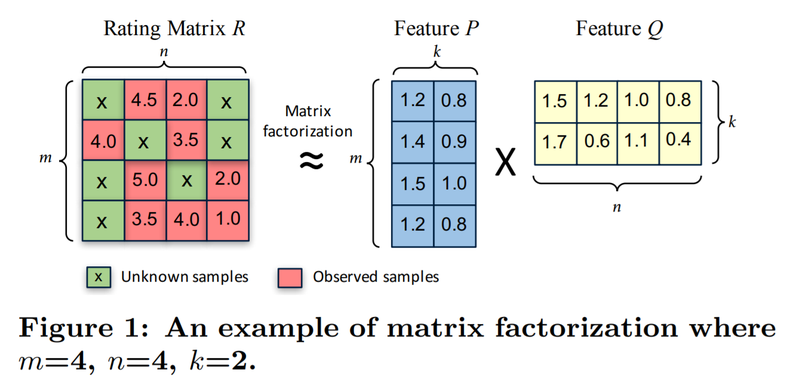

**MF의 아이디어**
>(m,n) 사이즈의 행렬 R을 (m,k) 사이즈의 행렬 P와 (k,n) 사이즈의 행렬 Q로 분해한다면 R이란 그저 P와 Q의 행렬곱으로 표현 가능하다!

#### - MF모델 사용 예시
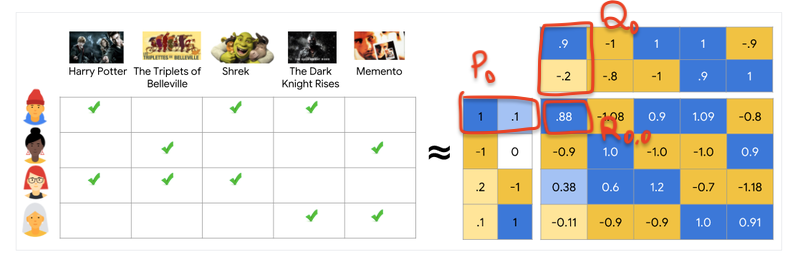

위 그림은 m = 4, n = 5, k = 2인 MF 모델.

$P_0=(1, 0.1)$은 빨간모자쓴 **사용자의 특성(Feature)벡터** <br>

$Q_0=(0.9, -0.2)$은 해리포터 **영화의 특성(Feature)벡터** <br>

이 두 벡터를 내적해서 얻어지는 0.88은 $R_{0,0}$로 정의되는 **사용자의 영화 선호도**

#### MF 모델의 목표는?
> - 모든 유저와 아이템에 대해 **k-dimension의 벡터를 잘 만드는 것**
> - 벡터를 잘 만드는 기준은 유저 i의 벡터($U_i$)와 아이템 j의 벡터($I_j$)를 내적했을 때 유저 i가 아이템 j에 대해 평가한 수치($M_{ij}$)와 비슷한지 <br>
> $U_i * I_j = M_{ij}$

### 4.1 MF 모델 학습전에 CSR matrix 만들기

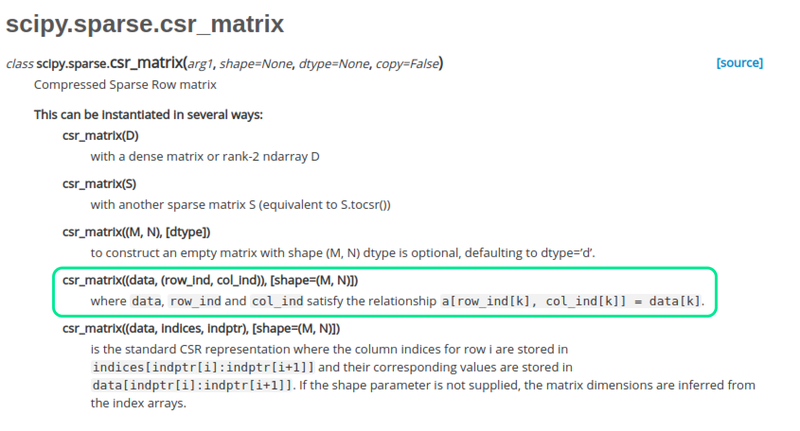

> - data[k]와 a[row_ind[k], col_ind[k]]가 같아야한다!

In [38]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique() 
num_movie = ratings['movie_id'].nunique()

print(num_user)
print(num_movie)
print(ratings['counts'].shape)
print(ratings['user_id'].shape)
print(ratings['movie_id'].shape)

# csr_data = csr_matrix((ratings.counts, (ratings.user_id, ratings.movie_id)), shape= (num_user, num_movie))
# csr_data

6040
3630
(836483,)
(836483,)
(836483,)


> 위에 코드를 주석 없이 실행시키면 **ValueError: row index exceeds matrix dimensions** 에러 발생

#### 왜이런 오류가 발생할까?

> - num_user = ratings['user_id'].nunique() 실제 데이터 인덱스와 다르게 들어간다. <br>
> - num_movie = ratings['movie_id'].nunique()와 다르게 실제 인덱스가 뒤죽박죽으로 매겨져있는듯하다
> - 모델 활용 전 전처리를 내맘대로해서 인덱싱이 제대로 안됐던거같다.<br>
> - 기존 실습 바탕으로 위에서 다시 indexing 해주자! -> 3.2 부분

In [44]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings.counts, (ratings.user_id, ratings.movie_id)), shape= (num_user, num_movie))
csr_data

<6040x3630 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

> #### 기존 실습대로 인덱싱 해주고 나니까 CSR matrix 만들 때 오류가 안난다!

### 4.2 모델 학습시키기

``implicit`` 패키지에 구현된 ``AlternatingLeastSquares`` 사용
- factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
- regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
- use_gpu : GPU를 사용할 것인지
- iterations : epochs와 같은 의미. 데이터를 몇 번 반복해서 학습할 것인지

In [45]:
!pip install implicit

In [46]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [47]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [48]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3630x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [49]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

# 5. 결과 분석
- 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

>- When Harry Met Sally... (1989)         6237
>- Clueless (1995)                        4670
>- Pretty Woman (1990)                    3572
>- Notting Hill (1999)                    2703
>- 10 Things I Hate About You (1999)      2210

In [50]:
my_favorite

[6237, 4670, 3572, 2703, 2210]

### my_favorite 인덱싱 전 후 비교
    Before After
- 0	 6237  3628	
- 1	 4670  3629	
- 2	 3572  2807	
- 3	 2703  3621	
- 4	 2210  2088

In [55]:
minyeong, clueless = user_to_idx[6041],movie_to_idx[4670]
minyeong_vector, clueless_vector = als_model.user_factors[minyeong],als_model.item_factors[clueless]

In [56]:
np.dot(minyeong_vector,clueless_vector)

0.0017248255

In [58]:
pref_movies=[]
for i in my_favorite:
    temp = movie_to_idx[i]
    pref_movies = np.dot(minyeong_vector, als_model.item_factors[temp])
    pref_movies.append((i,pref_movies))
    
pref_movies

AttributeError: 'numpy.float32' object has no attribute 'extend'

# 회고
- 제대로 완성을 못했다..
- 익스 미루지 말고 제때 하자 제발~!